In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import cv2
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
import os, glob, math, random
from datetime import datetime
from scipy import stats
from sklearn import metrics
import math
import pandas as pd
import rasterio
from datetime import datetime
from matplotlib.collections import LineCollection
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rasterio.plot import show as rio_show
import re
from rasterio.transform import array_bounds
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from tqdm import tqdm
import pickle
from matplotlib import patheffects as pe
import shapefile
import math, torch, torch.nn as nn, torch.nn.functional as F
import csv
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import gaussian_filter
import csv
import numpy as np
import torch
import scipy
import warnings
from matplotlib.patches import Patch

# Ignore all warnings
warnings.filterwarnings("ignore")
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
%load_ext autoreload
%autoreload 2
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader,Dataset
import torch
from tqdm import tqdm
import csv
from src.models import OriginalPlusMinimalAttentionDeepOld
from src.data import TempoPandoraInpaintDataset, Normalizer, load_classification_pickle, _rowcol_to_xy_vec, _wrap_lon_180, _lonlat_to_rowcol_vec, custom_collate_fn
from src.losses import calculate_metrics, improved_loss_progress
from src.utils import _add_shape,load_shapefile_segments_pyshp, generate_realistic_gaps_simple

df_missing = pd.read_csv("/work/srs108/pconv2d/missing.csv")

# Ensure the key column exists
if "percent_missing" not in df_missing.columns:
    raise ValueError("missing.csv must contain a 'percent_missing' column")

# --- Define thresholds ---
complete = df_missing[df_missing["percent_missing"] < 60]["filename"].tolist()
partial  = df_missing[
    (df_missing["percent_missing"] >= 60) & (df_missing["percent_missing"] < 75)
]["filename"].tolist()
blank    = df_missing[df_missing["percent_missing"] >= 75]["filename"].tolist()

# --- Split training/validation sets ---
train_files, val_files = train_test_split(complete, test_size=0.2, random_state=42)

tif_dir = '/work/srs108/bigs'
z = np.load("/hpc/home/srs108/normalizer_stats.npz", allow_pickle=True)
normalizer = Normalizer(clip_z=5.0)
normalizer.im_mu = float(z["im_mu"]); normalizer.im_sigma = float(z["im_sigma"])
shp_path="/work/srs108/pconv2d/cus/cb_2018_us_state_500k.shp"
pandora_df = pd.read_csv("/work/srs108/pconv2d/pandora_filtered_data_old.csv", header =0)
pandora_df["datetime"] = pd.to_datetime(pandora_df["datetime"], errors="coerce")
stations_all = pandora_df["station"].unique()
station_color_map = dict(zip(stations_all, cm.tab20c(np.linspace(0, 1, len(stations_all)))))

In [6]:
def count_missing_pixels_with_hist(tif_dir, missing_threshold=-1e+38, save_plot=None):
    """
    Count missing pixels in .tif rasters and plot a histogram color-coded by completeness.

    Parameters
    ----------
    tif_dir : str
        Directory containing .tif files.
    missing_threshold : float
        Any value below this threshold will be considered missing (~ -3.4e+38).
    save_plot : str or None
        Optional path to save the histogram (e.g. 'missing_hist.png').
        If None, the plot is just displayed.

    Returns
    -------
    pd.DataFrame
        DataFrame with filename, total pixels, missing pixels, percent missing, and category.
    """
    tif_files = os.listdir(tif_dir)  # Store filenames in a different variable
    results = []
    for tif_filename in tqdm(tif_files):  # Use the filenames list
        tif_path = os.path.join(tif_dir, tif_filename)  # Construct full path
        with rasterio.open(tif_path) as src:
            arr = src.read(1).astype(np.float64)
            total = arr.size
            missing_mask = (~np.isfinite(arr)) | (arr < missing_threshold)
            missing = np.sum(missing_mask)
            pct_missing = 100 * missing / total

        results.append({
            "filename": tif_path,
            "total_pixels": total,
            "missing_pixels": missing,
            "percent_missing": pct_missing
        })
        df = pd.DataFrame(results)
    print(f"\nProcessed {len(df)} images./nAverage missing pixels: {df['percent_missing'].mean():.2f}%")



    return df

df_missing = count_missing_pixels_with_hist(tif_dir, missing_threshold=-1e+38)
print(df_missing.sort_values("percent_missing", ascending=False).head())

# %%
df_missing.to_csv('/work/srs108/pconv2d/missing.csv', index=False)

# %%
# df_missing = pd.read_csv('/work/srs108/pconv2d/missing.csv', header=0)


100%|██████████| 5294/5294 [04:53<00:00, 18.05it/s]



Processed 5294 images./nAverage missing pixels: 45.11%
                                  filename  total_pixels  missing_pixels  \
4441  /work/srs108/bigs/20250601204004.tif        160000          160000   
1496  /work/srs108/bigs/20240629190515.tif        160000          160000   
219   /work/srs108/bigs/20240213204139.tif        160000          160000   
3049  /work/srs108/bigs/20250116184439.tif        160000          160000   
4755  /work/srs108/bigs/20250628190016.tif        160000          160000   

      percent_missing  
4441            100.0  
1496            100.0  
219             100.0  
3049            100.0  
4755            100.0  


📊 Saved histogram to missing_fraction_hist.png


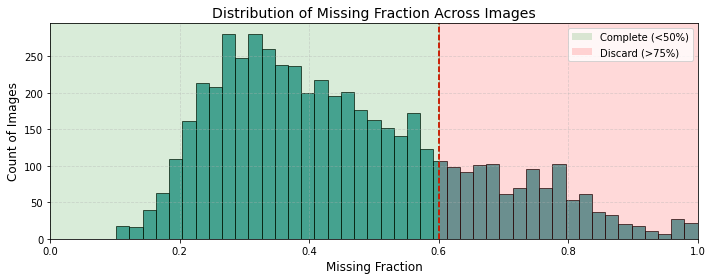

In [21]:
def plot_missing_fraction_distribution(df_missing, save_plot=None):
    """
    Plot histogram of missing pixel percentages with shaded regions and threshold lines.
    
    Parameters
    ----------
    df_missing : pd.DataFrame
        Must contain a 'percent_missing' column (0–100 range).
    save_plot : str or None
        Optional path to save the figure.
    """

    if "percent_missing" not in df_missing.columns:
        raise ValueError("DataFrame must include a 'percent_missing' column")

    # Convert to fraction [0–1] for plotting aesthetics like the example
    missing_frac = df_missing["percent_missing"] / 100.0

    fig, ax = plt.subplots(figsize=(10, 4))
    n, bins, patches = ax.hist(
        missing_frac,
        bins=np.linspace(0, 1, 50),
        color="teal",
        edgecolor="black",
        alpha=0.68
    )

    # --- Shaded completeness regions ---
    ax.axvspan(0, 0.60, color="green", alpha=0.15, label="Complete (<60%)")
    ax.axvspan(0.6, 1.0, color="red", alpha=0.15, label="Discard (>60%)")

    # --- Threshold lines ---
    ax.axvline(0.60, color="green", linestyle="--", lw=1.5)
    ax.axvline(0.6, color="red", linestyle="--", lw=1.5)

    # --- Labels and title ---
    ax.set_xlabel("Missing Fraction", fontsize=12)
    ax.set_ylabel("Count of Images", fontsize=12)
    ax.set_title("Distribution of Missing Fraction Across Images", fontsize=14)

    # --- Styling ---
    ax.set_xlim(0, 1.0)
    ax.grid(True, linestyle="--", alpha=0.4)

    # --- Legend ---
    legend_elems = [
        Patch(facecolor="green", alpha=0.15, label="Complete (<50%)"),
        Patch(facecolor="red", alpha=0.15, label="Discard (>75%)")
    ]
    ax.legend(handles=legend_elems, loc="upper right", frameon=True)

    plt.tight_layout()

    if save_plot:
        plt.savefig(save_plot, dpi=300, bbox_inches="tight", facecolor="white")
        print(f"📊 Saved histogram to {save_plot}")
    else:
        plt.show()

plot_missing_fraction_distribution(df_missing, save_plot="missing_fraction_hist.png")


In [7]:
def idw_inpaint(image, mask, power=2):
    """Naive inverse distance weighting fill for missing pixels."""
    known_y, known_x = np.where(mask > 0)
    unknown_y, unknown_x = np.where(mask == 0)
    filled = image.copy()

    for uy, ux in zip(unknown_y, unknown_x):
        dist2 = (known_y - uy)**2 + (known_x - ux)**2
        if np.any(dist2 == 0):  # directly known
            filled[uy, ux] = image[known_y[dist2 == 0][0], known_x[dist2 == 0][0]]
        else:
            w = 1.0 / (dist2 ** (power/2))
            w /= w.sum()
            filled[uy, ux] = np.sum(w * image[known_y, known_x])
    return filled


In [3]:
def telea_inpaint(image, mask):
    """Use OpenCV’s TELEA inpainting method."""
    img8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    hole_mask = (mask == 0).astype(np.uint8)
    filled = cv2.inpaint(img8, hole_mask, 3, cv2.INPAINT_TELEA)
    return filled.astype(np.float32) / 255.0


In [41]:
from pykrige.ok import OrdinaryKriging
import numpy as np

def kriging_inpaint(image, mask):
    """Ordinary Kriging interpolation for missing pixels (safe float fix)."""
    # Get valid coordinates and values
    y, x = np.where(mask > 0)
    vals = image[y, x]

    # Get missing coordinates
    missing_y, missing_x = np.where(mask == 0)

    # Require enough valid points for kriging to work
    if len(y) < 20 or np.all(np.isnan(vals)):
        return image

    # Cast to float64 (PyKrige expects float coords)
    x = x.astype(np.float64)
    y = y.astype(np.float64)
    vals = vals.astype(np.float64)
    missing_x = missing_x.astype(np.float64)
    missing_y = missing_y.astype(np.float64)

    try:
        OK = OrdinaryKriging(
            x, y, vals,
            variogram_model="spherical",
            verbose=False,
            enable_plotting=False
        )

        z, _ = OK.execute("points", missing_x, missing_y)
        filled = image.copy()
        filled[missing_y.astype(int), missing_x.astype(int)] = z
    except Exception as e:
        print(f"Kriging failed: {e}")
        filled = image

    return filled

def compute_metrics(pred, target, mask=None):
    """Compute MAE, RMSE, R2, and SSIM (robust to empty or tiny inputs)."""
    if mask is not None:
        valid = mask > 0.5
        pred, target = pred[valid], target[valid]

    # If no valid pixels, skip metrics
    if pred.size == 0 or target.size == 0:
        return {"MAE": np.nan, "RMSE": np.nan, "R2": np.nan,}

    # Compute standard metrics
    mae = mean_absolute_error(target, pred)
    rmse = np.sqrt(mean_squared_error(target, pred))
    r2 = r2_score(target, pred)

  
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def telea_inpaint(image, mask):
    """Use OpenCV’s TELEA inpainting method."""
    img8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    hole_mask = (mask == 0).astype(np.uint8)
    filled = cv2.inpaint(img8, hole_mask, 3, cv2.INPAINT_TELEA)
    return filled.astype(np.float32) / 255.0


# def evaluate_baselines(dataset, device="cuda"):
results = {"Kriging": []}


for sample in tqdm(val_ds):
    img = sample["target"].squeeze().numpy()
    mask = sample["known_mask"].squeeze().numpy()
    masked = sample["masked_img"].squeeze().numpy()

    gt = img
    known = mask > 0

    # ----- 1) IDW -----
#         start = time.time()
#         idw_pred = idw_inpaint(masked, known)
#         results["IDW"].append(compute_metrics(idw_pred, gt, ~known))
#         print("IDW took", time.time() - start)

#     ----- 2) Kriging -----
#     try:
    krig_pred = kriging_inpaint(masked, known)
    print(krig_pred)
    results["Kriging"].append(compute_metrics(krig_pred, gt, ~known))
#     except Exception:
#         pass

#         ----- 3) TELEA -----
#     telea_pred = telea_inpaint(masked, known)
#         print(telea_pred)
#     results["TELEA"].append(compute_metrics(telea_pred, gt, ~known))
#     print(results)
    # Aggregate results
#     mean_results = {k: {m: np.mean([r[m] for r in v if r]) for m in ["MAE", "RMSE", "R2"]}
#                     for k, v in results.items() if v}
#     return mean_results


  0%|          | 1/830 [00:07<1:44:25,  7.56s/it]

[[-0.766175   -0.76065445 -0.7572867  ... -1.7430847  -1.7773956
  -1.8084939 ]
 [-0.76931274 -0.7640422  -0.76128256 ... -1.7915171  -1.8300086
  -1.8645607 ]
 [-0.77278113 -0.76774377 -0.765379   ... -1.8405347  -1.884651
  -1.9238263 ]
 ...
 [ 1.0365815   0.7364108   0.3460038  ...  0.66802615  0.74473053
   0.7239328 ]
 [ 0.879164    0.9064306   0.87006956 ...  0.49670637  0.07601137
   0.42362267]
 [-0.14167407 -5.          0.19258767 ...  0.00972551 -0.20905967
   0.45664832]]


  0%|          | 2/830 [00:15<1:45:28,  7.64s/it]

[[-0.7063144  -0.14616914 -0.5353013  ...  0.03506979  0.00843018
  -0.04502173]
 [-0.7945644  -0.54842776 -0.5976238  ...  0.12888539  0.08981677
   0.01914761]
 [-0.16375858 -0.51168233 -0.5438039  ...  0.20794672  0.14696272
   0.05392198]
 ...
 [ 1.2564765   1.1943496   0.92361397 ...  0.28506124  0.23322096
   0.4066085 ]
 [-0.07000577  0.30408463  0.47691113 ...  0.38796043 -0.25472686
  -0.04576433]
 [-0.8827604   0.4089934  -0.00548837 ...  0.51815933 -0.9393332
  -0.9017009 ]]


  0%|          | 2/830 [00:18<2:08:01,  9.28s/it]


KeyboardInterrupt: 

In [36]:

def aggregate_results(results_dict):
    mean_results = {}
    for model, metrics in results_dict.items():
        # Filter out invalid entries (None, empty dicts, NaN values)
        valid_metrics = [m for m in metrics if isinstance(m, dict) and len(m) > 0]

        if not valid_metrics:
            mean_results[model] = {"MAE": np.nan, "RMSE": np.nan, "R2": np.nan}
            continue

        df = pd.DataFrame(valid_metrics)

        # Compute mean ignoring NaNs
        mean_results[model] = {
            "MAE": np.nanmean(df["MAE"].to_numpy(dtype=float)),
            "RMSE": np.nanmean(df["RMSE"].to_numpy(dtype=float)),
            "R2": np.nanmean(df["R2"].to_numpy(dtype=float)),
        }

    return mean_results
mean_results = aggregate_results(results)
mean_results

{'TELEA': {'MAE': 5.650252897078592, 'RMSE': 5.651737539759486, 'R2': 0.0}}

In [19]:
import zlib
class TempoPandoraInpaintDataset(Dataset):
    F32_MIN = np.float32(-3.4028235e+38).item()
    def __init__(self,
                 tif_dir,
                 normalizer,
                 file_list,
                 train,
                 use_dataset_mask=True,
                 treat_zeros_as_missing=False,
                 valid_range=None,
                pandora_csv=None,
                time_tolerance="30min",
                n_blobs_range=(1, 5),
                sigma_xy_range=(5.0, 25.0),  # Spatial smoothing range
                thr_range=(0.3, 0.7),       # Threshold range for hole creation
                use_blob_gaps=True,
                crop_size=(128, 128),
                random_crop=True,
                center_crop_val=True):
        
        self.tif_dir = tif_dir
        self.train= train
        self.normalizer = normalizer
        self.use_dataset_mask = bool(use_dataset_mask)
        self.treat_zeros_as_missing = bool(treat_zeros_as_missing)
        self.valid_range = valid_range
        self.crop_size = crop_size
        self.random_crop = random_crop
        self.center_crop_val = bool(center_crop_val)

        self.files = list(file_list)
        self.timestamps = []
        for p in self.files:
            ts = self._parse_time_from_fname(os.path.basename(p))
            self.timestamps.append(ts)

        order = np.argsort(np.array(self.timestamps, dtype='datetime64[ns]'))
        self.files = [self.files[i] for i in order]
        self.timestamps = [self.timestamps[i] for i in order]
        
        self.n_blobs_range = n_blobs_range
        self.sigma_xy_range = sigma_xy_range
        self.thr_range = thr_range
        self.use_blob_gaps = use_blob_gaps
        self.current_epoch = 0
        self.max_epochs = 1 
        
        self.pandora_df = None
        self.time_tolerance = pd.Timedelta(time_tolerance)
        if pandora_csv is not None:
            if isinstance(pandora_csv, pd.DataFrame):
                df = pandora_csv.copy()
            else:
                df = pd.read_csv(pandora_csv)

            req = {"datetime","NO2"}
            df["datetime"] = pd.to_datetime(df["datetime"])
            df = df.sort_values("datetime").reset_index(drop=True)
            self.pandora_df = df

    def _random_or_center_crop(self, img_dict):
        H = W = None
        for v in img_dict.values():
            if isinstance(v, np.ndarray) and v.ndim == 2:
                H, W = v.shape
                break
        if H is None:
            raise ValueError("No 2D arrays found in img_dict to crop.")

        ch, cw = self.crop_size
        if H < ch or W < cw:
            raise ValueError(f"Crop size {self.crop_size} exceeds image size ({H},{W})")

        if self.random_crop:  # training
            y0 = np.random.randint(0, H - ch + 1)
            x0 = np.random.randint(0, W - cw + 1)

        else:                 # validation
            path = str(img_dict.get("path", ""))
            ts   = str(img_dict.get("ts", ""))
            yhash = zlib.adler32((path + "|y|" + ts).encode("utf-8"))
            xhash = zlib.adler32((path + "|x|" + ts).encode("utf-8"))
            y0 = int(yhash % (H - ch + 1))
            x0 = int(xhash % (W - cw + 1))

        cropped = {}
        for k, v in img_dict.items():
            if isinstance(v, np.ndarray) and v.ndim == 2:
                cropped[k] = v[y0:y0 + ch, x0:x0 + cw]
            else:
                cropped[k] = v  # keep metadata (e.g., 'path', 'ts')

        cropped["crop_origin"] = (int(y0), int(x0))          # (row0, col0) in the ORIGINAL
        cropped["crop_size"]   = (int(ch), int(cw))          # (Hc, Wc)
        return cropped, (int(y0), int(x0))

    # ---------- core I/O & masking ----------
    def _read_band_masked(self, path):
        with rasterio.open(path) as src:
            gdal_known = None
            if self.use_dataset_mask:
                try:
                    m = src.read_masks(1)  # 0=missing, 255=valid
                    if m is not None and m.size:
                        gdal_known = (m > 0)
                except Exception:
                    gdal_known = None

            arr = src.read(1, out_dtype='float64')
            nodatas = []
            if getattr(src, "nodata", None) is not None:
                nodatas.append(src.nodata)
            if getattr(src, "nodatavals", None):
                nodatas += [v for v in src.nodatavals if v is not None]

        known = gdal_known if gdal_known is not None else np.isfinite(arr)
        for nv in nodatas:
            known &= arr != nv
        known &= arr > (self.F32_MIN * 0.9)
        if self.treat_zeros_as_missing:
            known &= arr != 0.0
        if self.valid_range is not None:
            vmin, vmax = self.valid_range
            known &= (arr >= vmin) & (arr <= vmax)

        arr_valid = np.where(known, arr, np.nan)
        return arr_valid, known.astype(np.uint8)

    @staticmethod
    def _parse_time_from_fname(fname):
        digits = re.sub(r"\D", "", fname)
        for fmt in ("%Y%m%d%H%M%S", "%Y%m%d%H%M", "%Y%m%d%H", "%Y%m%d"):
            try:
                return pd.to_datetime(digits[:len(pd.Timestamp.now().strftime(fmt))], format=fmt)
            except Exception:
                continue
        return pd.NaT
            
    
    def _make_2d_blob_mask(self, H, W, keep_mask_2d, rng, min_frac=0.05, 
                           max_frac=0.25,n_blobs_range=(10, 25),sigma_xy_range=(4, 15)):
 
        keep = np.ones((H, W), dtype=np.float32)
        valid = keep_mask_2d.astype(bool)
        if not valid.any():
            return keep

        n_blobs = int(rng.integers(*n_blobs_range))
        if n_blobs <= 0:
            return keep
        target_frac = float(rng.uniform(min_frac, max_frac))
        y_grid, x_grid = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")
        prob_field = np.zeros((H, W), dtype=np.float32)
        for _ in range(n_blobs):
            y_c = rng.integers(0, H)
            x_c = rng.integers(0, W)
            sigma = float(rng.uniform(*sigma_xy_range))

            dist = np.sqrt(((y_grid - y_c) / max(1, sigma))**2 + ((x_grid - x_c) / max(1, sigma))**2)
            prob_field += np.exp(-dist**2 / 2)

        prob_field -= prob_field.min()
        if prob_field.max() > 0:
            prob_field /= prob_field.max()

        random_field = rng.uniform(0, 1, (H, W)).astype(np.float32)
        holes = (random_field < prob_field * 0.8) & valid
        if holes.mean() > target_frac:
            thresh = np.quantile(prob_field[valid], 1.0 - target_frac)
            holes = (prob_field >= thresh) & valid

        keep = np.ones((H, W), dtype=np.float32)
        keep[holes] = 0.0
        return keep

    def _make_progressive_mask(self, H, W, keep_mask_2d, rng, epoch, max_epochs):
        frac = min(epoch / max_epochs, 1.0)  # goes 0 → 1
        max_cover = 0.45  # 25% max
        min_cover = 0.05  # 5% start
        cover_frac = min_cover + frac * (max_cover - min_cover)

        keep = self._make_2d_blob_mask(H, W, keep_mask_2d, rng)
        return keep
    
    def __len__(self): return len(self.files)

    def __getitem__(self,idx):   
        path = self.files[idx]
        arr_valid, known_mask = self._read_band_masked(path)
        img = np.nan_to_num(arr_valid, nan=0.0).astype(np.float64)
        H, W = img.shape
        img_n = self.normalizer.normalize_image(img) 

        pandora_mask = np.zeros((H, W), dtype=np.float32)
        pandora_val_map = np.zeros((H, W), dtype=np.float32)
        xy_list, val_list = [], []
        station_names = []

        ts = self._parse_time_from_fname(os.path.basename(path))
        if (self.pandora_df is not None) and (ts is not pd.NaT):
            dfw = self.pandora_df[
                (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                (self.pandora_df["datetime"] <= ts + self.time_tolerance)
            ].copy()

            if not dfw.empty:
                if "station" in dfw.columns:
                    dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                    dfw = dfw.sort_values(["station","abs_dt"]).groupby("station", as_index=False).first()

                if ("row" in dfw.columns) and ("col" in dfw.columns):
                    rows = dfw["row"].astype(int).to_numpy()
                    cols = dfw["col"].astype(int).to_numpy()
                else:
                    with rasterio.open(path) as src:
                        tr = src.transform
                    if not {"lat","lon"}.issubset(set(dfw.columns)):
                        rows, cols = np.array([], dtype=int), np.array([], dtype=int)
                    else:
                        xs = dfw["lon"].to_numpy()
                        ys = dfw["lat"].to_numpy()
                        rc = [~tr * (x, y) for x, y in zip(xs, ys)]
                        cols = np.array([int(round(c)) for c, r in rc])
                        rows = np.array([int(round(r)) for c, r in rc])

                ok = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)
                rows, cols = rows[ok], cols[ok]
                vals = dfw.loc[ok, "NO2"].astype(float).to_numpy()

                dfw_ok = dfw.loc[ok].reset_index(drop=True)  # Filter dataframe to match valid coordinates
                station_names_raw = dfw_ok["station"].astype(str).to_numpy() if "station" in dfw_ok.columns else []

                vals_n = vals.astype(np.float32)  # identity

                for i, (r, c, v_n) in enumerate(zip(rows, cols, vals_n)):
                    pandora_mask[r, c] = 1.0
                    pandora_val_map[r, c] = v_n
                    xy_list.append((int(r), int(c)))

                    if i < len(station_names_raw): station_names.append(station_names_raw[i])
                    else: station_names.append(f"Unknown_{i}")

                val_list = vals_n.tolist()

        if self.train:
            if self.use_blob_gaps:
                rng = np.random.default_rng()
                realistic_gaps = self._make_progressive_mask(H,W,known_mask, rng, 
                                                   epoch=self.current_epoch, max_epochs = self.max_epochs)
#                 realistic_gaps = self._make_2d_blob_mask(H, W, known_mask, rng)
            all_masks = known_mask * realistic_gaps
            img_with_holes = img_n * all_masks

            img_dict = {
            "masked_img": img_with_holes,
            "known_and_fake_mask": all_masks,
            "known_mask": known_mask,
            "fake_mask": realistic_gaps,
            "target": img_n,
            "p_mask": pandora_mask,
            "p_val_mask": pandora_val_map
        }
            cropped, (y0, x0) = self._random_or_center_crop(img_dict)

            sample = {
                'path': path,
                "station_names":station_names,
                "masked_img": torch.from_numpy(cropped["masked_img"]).unsqueeze(0).float(),
                "known_mask": torch.from_numpy(cropped["known_mask"]).unsqueeze(0).float(),
                "target":     torch.from_numpy(cropped["target"]).unsqueeze(0).float(),
                "known_and_fake_mask": torch.from_numpy(cropped.get("known_and_fake_mask", cropped["known_mask"])).unsqueeze(0).float(),
                "fake_mask": torch.from_numpy(cropped.get("fake_mask", np.ones_like(cropped["known_mask"], dtype=np.float32))).unsqueeze(0).float(),
                "p_mask":     torch.from_numpy(cropped.get("p_mask", np.zeros_like(cropped["known_mask"], dtype=np.float32))).unsqueeze(0).float(),
                "p_val_mask": torch.from_numpy(cropped.get("p_val_mask", np.zeros_like(cropped["known_mask"], dtype=np.float32))).unsqueeze(0).float(),
                "crop_origin": (int(y0), int(x0)),           # (row, col)
                "crop_size":   (int(cropped["target"].shape[0]), int(cropped["target"].shape[1]))  # (Hc, Wc)
            }
            return sample


        else:  # validation
            if not self.train and self.center_crop_val:
                img_dict = {
                    "masked_img": img_n,
                    "known_mask": known_mask,
                    "target": img_n,
                    "p_mask": pandora_mask,
                    "p_val_mask": pandora_val_map
                }
                cropped, (y0, x0) = self._random_or_center_crop(img_dict)

                sample = {
                    "p_mask": torch.from_numpy(cropped["p_mask"]).unsqueeze(0).float(),
                    "p_val_mask": torch.from_numpy(cropped["p_val_mask"]).unsqueeze(0).float(),
                    "station_names": station_names,
                    "masked_img": torch.from_numpy(cropped["masked_img"]).unsqueeze(0).float(),
                    "known_mask": torch.from_numpy(cropped["known_mask"]).unsqueeze(0).float(),
                    "target": torch.from_numpy(cropped["target"]).unsqueeze(0).float(),
                    "path": path,
                    "crop_origin": (int(y0), int(x0)),
                    "crop_size": (int(cropped["target"].shape[0]), int(cropped["target"].shape[1]))}
            else:
                # full 400×400 validation for inference 
                H, W = img_n.shape
                y0, x0 = 0, 0
                cropped = {
                    "masked_img": img_n,
                    "known_mask": known_mask,
                    "target": img_n,
                    "p_mask": pandora_mask,
                    "p_val_mask": pandora_val_map}

                sample = {
                    "p_mask": torch.from_numpy(cropped["p_mask"]).unsqueeze(0).float(),
                    "p_val_mask": torch.from_numpy(cropped["p_val_mask"]).unsqueeze(0).float(),
                    "station_names": station_names,
                    "masked_img": torch.from_numpy(cropped["masked_img"]).unsqueeze(0).float(),
                    "known_mask": torch.from_numpy(cropped["known_mask"]).unsqueeze(0).float(),
                    "target": torch.from_numpy(cropped["target"]).unsqueeze(0).float(),
                    "path": path,
                    "crop_origin": (int(y0), int(x0)),
                    "crop_size": (int(H), int(W))}
            return sample
val_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,
                            file_list=val_files,pandora_csv=pandora_df, 
                            random_crop=False, center_crop_val=True) #true, training validation center

# val_loader = DataLoader(val_ds,batch_size=4, shuffle=False, collate_fn=custom_collate_fn, num_workers=0)


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
mean_results = evaluate_baselines(val_ds, pconv_model=False, device=device)
print(mean_results)

  0%|          | 2/830 [00:00<02:00,  6.89it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}]}
{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}]}


  1%|          | 5/830 [00:00<01:35,  8.64it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}]}
{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}]}
{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}]}


  1%|          | 7/830 [00:00<01:31,  9.02it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}]}
{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}]}


  1%|          | 9/830 [00:01<01:29,  9.17it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}, {'MAE': 5.713492, 'RMSE': 5.714473, 'R2': 0.0}]}
{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}, {'MAE': 5.713492, 'RMSE': 5.714473, 'R2': 0.0}, {'MAE': 5.6943507, 'RMSE': 5.695195, 'R2': 0.0}]}


  1%|▏         | 11/830 [00:01<01:27,  9.35it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}, {'MAE': 5.713492, 'RMSE': 5.714473, 'R2': 0.0}, {'MAE': 5.6943507, 'RMSE': 5.695195, 'R2': 0.0}, {'MAE': 5.694982, 'RMSE': 5.6960087, 'R2': 0.0}]}
{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}, {'MAE': 5.713492, 'RMSE': 5.714473, 'R2': 0.0}, {'MAE': 5.6943507, 'RMSE': 5.695195, 'R2': 0.0}

  2%|▏         | 13/830 [00:01<01:25,  9.61it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}, {'MAE': 5.713492, 'RMSE': 5.714473, 'R2': 0.0}, {'MAE': 5.6943507, 'RMSE': 5.695195, 'R2': 0.0}, {'MAE': 5.694982, 'RMSE': 5.6960087, 'R2': 0.0}, {'MAE': 5.6862164, 'RMSE': 5.687058, 'R2': 0.0}, {'MAE': 5.6049013, 'RMSE': 5.606672, 'R2': 0.0}]}
{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0

  2%|▏         | 14/830 [00:01<01:24,  9.64it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}, {'MAE': 5.713492, 'RMSE': 5.714473, 'R2': 0.0}, {'MAE': 5.6943507, 'RMSE': 5.695195, 'R2': 0.0}, {'MAE': 5.694982, 'RMSE': 5.6960087, 'R2': 0.0}, {'MAE': 5.6862164, 'RMSE': 5.687058, 'R2': 0.0}, {'MAE': 5.6049013, 'RMSE': 5.606672, 'R2': 0.0}, {'MAE': 5.5921316, 'RMSE': 5.5941243, 'R2': 0.0}, {'MAE': 5.6100655, 'RMSE': 5.61147, 'R2': 0.0}]}
{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.

  2%|▏         | 17/830 [00:01<01:23,  9.79it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}, {'MAE': 5.713492, 'RMSE': 5.714473, 'R2': 0.0}, {'MAE': 5.6943507, 'RMSE': 5.695195, 'R2': 0.0}, {'MAE': 5.694982, 'RMSE': 5.6960087, 'R2': 0.0}, {'MAE': 5.6862164, 'RMSE': 5.687058, 'R2': 0.0}, {'MAE': 5.6049013, 'RMSE': 5.606672, 'R2': 0.0}, {'MAE': 5.5921316, 'RMSE': 5.5941243, 'R2': 0.0}, {'MAE': 5.6100655, 'RMSE': 5.61147, 'R2': 0.0}, {'MAE': 5.6456285, 'RMSE': 5.646, 'R2': 0.0}, {'MAE': 5.7048197, 'RMSE': 5.705461, 'R2': 0.0}]}
{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}

  2%|▏         | 19/830 [00:02<01:23,  9.71it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}, {'MAE': 5.713492, 'RMSE': 5.714473, 'R2': 0.0}, {'MAE': 5.6943507, 'RMSE': 5.695195, 'R2': 0.0}, {'MAE': 5.694982, 'RMSE': 5.6960087, 'R2': 0.0}, {'MAE': 5.6862164, 'RMSE': 5.687058, 'R2': 0.0}, {'MAE': 5.6049013, 'RMSE': 5.606672, 'R2': 0.0}, {'MAE': 5.5921316, 'RMSE': 5.5941243, 'R2': 0.0}, {'MAE': 5.6100655, 'RMSE': 5.61147, 'R2': 0.0}, {'MAE': 5.6456285, 'RMSE': 5.646, 'R2': 0.0}, {'MAE': 5.7048197, 'RMSE': 5.705461, 'R2': 0.0}, {'MAE': 5.644257, 'RMSE': 5.645805, 'R2': 0.0}, {'MAE': 5.68612, 'RMSE': 5.6876035, 'R2': 0.0}]}
{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, 

  3%|▎         | 21/830 [00:02<01:24,  9.54it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}, {'MAE': 5.713492, 'RMSE': 5.714473, 'R2': 0.0}, {'MAE': 5.6943507, 'RMSE': 5.695195, 'R2': 0.0}, {'MAE': 5.694982, 'RMSE': 5.6960087, 'R2': 0.0}, {'MAE': 5.6862164, 'RMSE': 5.687058, 'R2': 0.0}, {'MAE': 5.6049013, 'RMSE': 5.606672, 'R2': 0.0}, {'MAE': 5.5921316, 'RMSE': 5.5941243, 'R2': 0.0}, {'MAE': 5.6100655, 'RMSE': 5.61147, 'R2': 0.0}, {'MAE': 5.6456285, 'RMSE': 5.646, 'R2': 0.0}, {'MAE': 5.7048197, 'RMSE': 5.705461, 'R2': 0.0}, {'MAE': 5.644257, 'RMSE': 5.645805, 'R2': 0.0}, {'MAE': 5.68612, 'RMSE': 5.6876035, 'R2': 0.0}, {'MAE': 5.727672, 'RMSE': 5.7279053, 'R2': 0.0}, {'MAE': 5.7016487, 'RMSE': 5.702973, 'R

  3%|▎         | 23/830 [00:02<01:24,  9.50it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}, {'MAE': 5.713492, 'RMSE': 5.714473, 'R2': 0.0}, {'MAE': 5.6943507, 'RMSE': 5.695195, 'R2': 0.0}, {'MAE': 5.694982, 'RMSE': 5.6960087, 'R2': 0.0}, {'MAE': 5.6862164, 'RMSE': 5.687058, 'R2': 0.0}, {'MAE': 5.6049013, 'RMSE': 5.606672, 'R2': 0.0}, {'MAE': 5.5921316, 'RMSE': 5.5941243, 'R2': 0.0}, {'MAE': 5.6100655, 'RMSE': 5.61147, 'R2': 0.0}, {'MAE': 5.6456285, 'RMSE': 5.646, 'R2': 0.0}, {'MAE': 5.7048197, 'RMSE': 5.705461, 'R2': 0.0}, {'MAE': 5.644257, 'RMSE': 5.645805, 'R2': 0.0}, {'MAE': 5.68612, 'RMSE': 5.6876035, 'R2': 0.0}, {'MAE': 5.727672, 'RMSE': 5.7279053, 'R2': 0.0}, {'MAE': 5.7016487, 'RMSE': 5.702973, 'R

  3%|▎         | 25/830 [00:02<01:23,  9.63it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}, {'MAE': 5.713492, 'RMSE': 5.714473, 'R2': 0.0}, {'MAE': 5.6943507, 'RMSE': 5.695195, 'R2': 0.0}, {'MAE': 5.694982, 'RMSE': 5.6960087, 'R2': 0.0}, {'MAE': 5.6862164, 'RMSE': 5.687058, 'R2': 0.0}, {'MAE': 5.6049013, 'RMSE': 5.606672, 'R2': 0.0}, {'MAE': 5.5921316, 'RMSE': 5.5941243, 'R2': 0.0}, {'MAE': 5.6100655, 'RMSE': 5.61147, 'R2': 0.0}, {'MAE': 5.6456285, 'RMSE': 5.646, 'R2': 0.0}, {'MAE': 5.7048197, 'RMSE': 5.705461, 'R2': 0.0}, {'MAE': 5.644257, 'RMSE': 5.645805, 'R2': 0.0}, {'MAE': 5.68612, 'RMSE': 5.6876035, 'R2': 0.0}, {'MAE': 5.727672, 'RMSE': 5.7279053, 'R2': 0.0}, {'MAE': 5.7016487, 'RMSE': 5.702973, 'R

  3%|▎         | 28/830 [00:03<01:21,  9.80it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}, {'MAE': 5.713492, 'RMSE': 5.714473, 'R2': 0.0}, {'MAE': 5.6943507, 'RMSE': 5.695195, 'R2': 0.0}, {'MAE': 5.694982, 'RMSE': 5.6960087, 'R2': 0.0}, {'MAE': 5.6862164, 'RMSE': 5.687058, 'R2': 0.0}, {'MAE': 5.6049013, 'RMSE': 5.606672, 'R2': 0.0}, {'MAE': 5.5921316, 'RMSE': 5.5941243, 'R2': 0.0}, {'MAE': 5.6100655, 'RMSE': 5.61147, 'R2': 0.0}, {'MAE': 5.6456285, 'RMSE': 5.646, 'R2': 0.0}, {'MAE': 5.7048197, 'RMSE': 5.705461, 'R2': 0.0}, {'MAE': 5.644257, 'RMSE': 5.645805, 'R2': 0.0}, {'MAE': 5.68612, 'RMSE': 5.6876035, 'R2': 0.0}, {'MAE': 5.727672, 'RMSE': 5.7279053, 'R2': 0.0}, {'MAE': 5.7016487, 'RMSE': 5.702973, 'R

  4%|▎         | 30/830 [00:03<01:22,  9.66it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}, {'MAE': 5.713492, 'RMSE': 5.714473, 'R2': 0.0}, {'MAE': 5.6943507, 'RMSE': 5.695195, 'R2': 0.0}, {'MAE': 5.694982, 'RMSE': 5.6960087, 'R2': 0.0}, {'MAE': 5.6862164, 'RMSE': 5.687058, 'R2': 0.0}, {'MAE': 5.6049013, 'RMSE': 5.606672, 'R2': 0.0}, {'MAE': 5.5921316, 'RMSE': 5.5941243, 'R2': 0.0}, {'MAE': 5.6100655, 'RMSE': 5.61147, 'R2': 0.0}, {'MAE': 5.6456285, 'RMSE': 5.646, 'R2': 0.0}, {'MAE': 5.7048197, 'RMSE': 5.705461, 'R2': 0.0}, {'MAE': 5.644257, 'RMSE': 5.645805, 'R2': 0.0}, {'MAE': 5.68612, 'RMSE': 5.6876035, 'R2': 0.0}, {'MAE': 5.727672, 'RMSE': 5.7279053, 'R2': 0.0}, {'MAE': 5.7016487, 'RMSE': 5.702973, 'R

  4%|▍         | 32/830 [00:03<01:32,  8.67it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}, {'MAE': 5.713492, 'RMSE': 5.714473, 'R2': 0.0}, {'MAE': 5.6943507, 'RMSE': 5.695195, 'R2': 0.0}, {'MAE': 5.694982, 'RMSE': 5.6960087, 'R2': 0.0}, {'MAE': 5.6862164, 'RMSE': 5.687058, 'R2': 0.0}, {'MAE': 5.6049013, 'RMSE': 5.606672, 'R2': 0.0}, {'MAE': 5.5921316, 'RMSE': 5.5941243, 'R2': 0.0}, {'MAE': 5.6100655, 'RMSE': 5.61147, 'R2': 0.0}, {'MAE': 5.6456285, 'RMSE': 5.646, 'R2': 0.0}, {'MAE': 5.7048197, 'RMSE': 5.705461, 'R2': 0.0}, {'MAE': 5.644257, 'RMSE': 5.645805, 'R2': 0.0}, {'MAE': 5.68612, 'RMSE': 5.6876035, 'R2': 0.0}, {'MAE': 5.727672, 'RMSE': 5.7279053, 'R2': 0.0}, {'MAE': 5.7016487, 'RMSE': 5.702973, 'R

  4%|▍         | 34/830 [00:03<01:28,  9.04it/s]

{'IDW': [], 'Kriging': [], 'TELEA': [{'MAE': 5.5901246, 'RMSE': 5.5938797, 'R2': 0.0}, {'MAE': 5.581532, 'RMSE': 5.5847836, 'R2': 0.0}, {'MAE': 5.6987348, 'RMSE': 5.699237, 'R2': 0.0}, {'MAE': 5.7184224, 'RMSE': 5.7193985, 'R2': 0.0}, {'MAE': 5.729864, 'RMSE': 5.73039, 'R2': 0.0}, {'MAE': 5.701439, 'RMSE': 5.7022004, 'R2': 0.0}, {'MAE': 5.562908, 'RMSE': 5.564696, 'R2': 0.0}, {'MAE': 5.713492, 'RMSE': 5.714473, 'R2': 0.0}, {'MAE': 5.6943507, 'RMSE': 5.695195, 'R2': 0.0}, {'MAE': 5.694982, 'RMSE': 5.6960087, 'R2': 0.0}, {'MAE': 5.6862164, 'RMSE': 5.687058, 'R2': 0.0}, {'MAE': 5.6049013, 'RMSE': 5.606672, 'R2': 0.0}, {'MAE': 5.5921316, 'RMSE': 5.5941243, 'R2': 0.0}, {'MAE': 5.6100655, 'RMSE': 5.61147, 'R2': 0.0}, {'MAE': 5.6456285, 'RMSE': 5.646, 'R2': 0.0}, {'MAE': 5.7048197, 'RMSE': 5.705461, 'R2': 0.0}, {'MAE': 5.644257, 'RMSE': 5.645805, 'R2': 0.0}, {'MAE': 5.68612, 'RMSE': 5.6876035, 'R2': 0.0}, {'MAE': 5.727672, 'RMSE': 5.7279053, 'R2': 0.0}, {'MAE': 5.7016487, 'RMSE': 5.702973, 'R

KeyboardInterrupt: 